# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
do_random = False # draw new coeff with bootstrap resampling?
do_random = True # draw new coeff at random

do_double_shuffle = True # shuffle accross dictionary elements
do_double_shuffle = False # only shuffles 

l0_sparseness_noise = 200 #shl.n_dictionary #

In [4]:
tag = 'coding'
homeo_methods = ['None', 'HAP', 'HEH']

record_num_batches = 2**12

seed = 42
np.random.seed(seed)

from shl_scripts.shl_experiments import SHL
shl = SHL()
data = shl.get_data(matname=tag + '_test')
indx = np.random.permutation(data.shape[0])[:record_num_batches]

list_figures = []

dico = {}
for homeo_method in homeo_methods:
    print(15*'🐶' + homeo_method[:3] + 15*'🐶')
    shl = SHL(homeo_method=homeo_method)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)


🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶Non🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶Non🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 441)
average of codewords =  0.021260058913248107
average std of codewords =  0.14129595968473393
l0-sparseness of codewords =  0.029444688031462586
std of the average of individual patches =  0.0053773288063877775


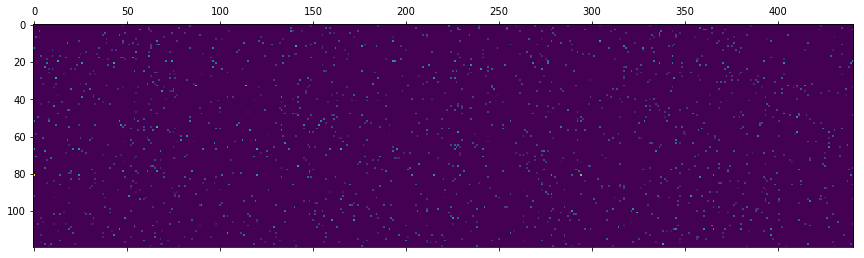

<Figure size 1080x216 with 0 Axes>

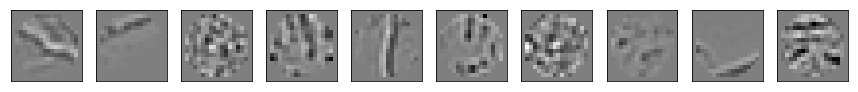

number of codes, size of reconstructed images =  (4096, 324)


<Figure size 1080x216 with 0 Axes>

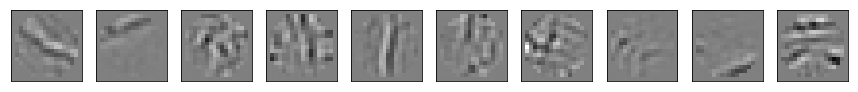

<Figure size 1080x216 with 0 Axes>

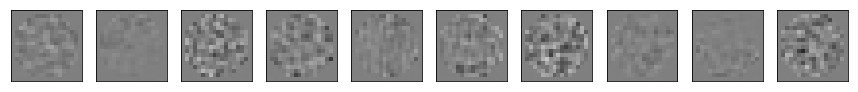

average of data patches =  -0.000120224792836511 +/- 0.005833718807624337
average of residual patches =  -0.00025231504492298956 +/- 0.004573792683333387
median energy of data =  0.18799682320600752
average energy of data =  0.1886447531819535 +/- 0.07023119141832547
average error =  -0.00025231504492298956 +/- 0.11294762984094749
average energy of residual =  0.10342238166602491 +/- 0.045398697339204167
median energy of residual =  0.10194864709381725
average gain of coding =  1.9098263768323036 +/- 0.3729010609143206
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 441)
average of codewords =  0.02121953631149483
average std of codewords =  0.14118315862309772
l0-sparseness of codewords =  0.029446348852040817
std of the average of individual patches =  0.005536449637820798


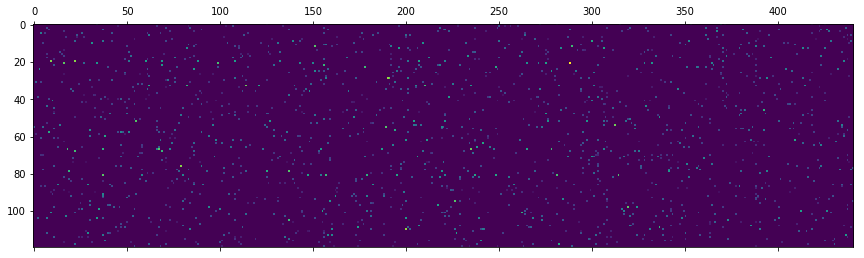

<Figure size 1080x216 with 0 Axes>

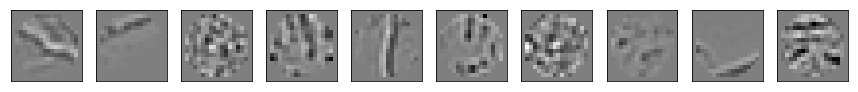

number of codes, size of reconstructed images =  (4096, 324)


<Figure size 1080x216 with 0 Axes>

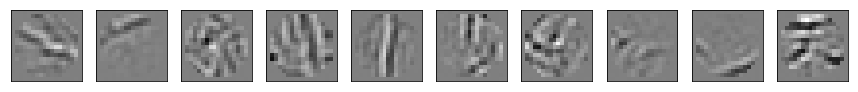

<Figure size 1080x216 with 0 Axes>

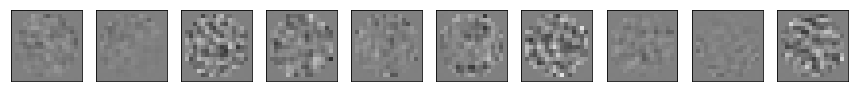

average of data patches =  -0.000120224792836511 +/- 0.005833718807624337
average of residual patches =  0.00037611623085780874 +/- 0.004539653501046525
median energy of data =  0.18799682320600752
average energy of data =  0.1886447531819535 +/- 0.07023119141832547
average error =  0.00037611623085780874 +/- 0.11322004089810779
average energy of residual =  0.10368394545743864 +/- 0.04548140915546932
median energy of residual =  0.1013314199751286
average gain of coding =  1.9065531983942308 +/- 0.37737647332905444
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 441)
average of codewords =  0.021480230277494686
average std of codewords =  0.1427632353510123
l0-sparseness of codewords =  0.02944081278344671
std of the average of individual patches =  0.0035999640613647538


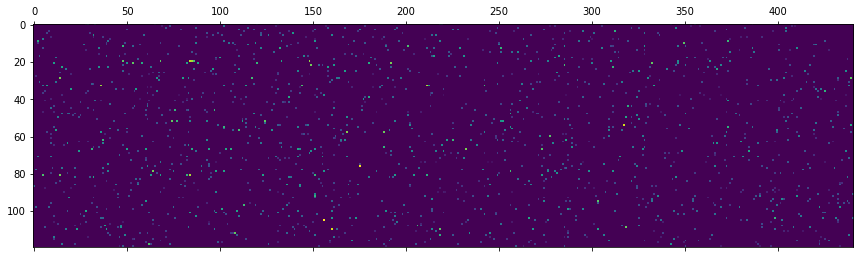

<Figure size 1080x216 with 0 Axes>

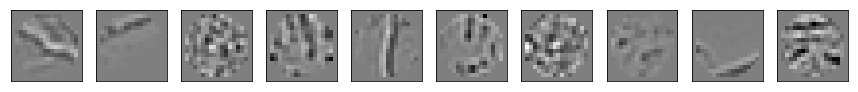

number of codes, size of reconstructed images =  (4096, 324)


<Figure size 1080x216 with 0 Axes>

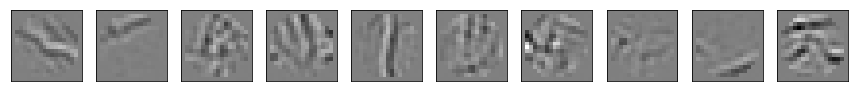

<Figure size 1080x216 with 0 Axes>

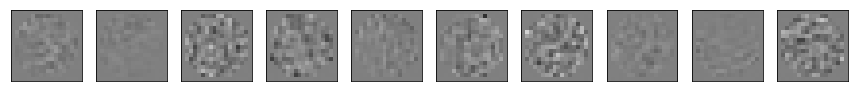

average of data patches =  -0.000120224792836511 +/- 0.005833718807624337
average of residual patches =  -0.0001585403502314553 +/- 0.004688538240466118
median energy of data =  0.18799682320600752
average energy of data =  0.1886447531819535 +/- 0.07023119141832547
average error =  -0.0001585403502314553 +/- 0.11042721007902286
average energy of residual =  0.10118380110891935 +/- 0.04422705341790185
median energy of residual =  0.09967296007639351
average gain of coding =  1.9514255393132391 +/- 0.38822573477467387


In [11]:
from shl_scripts.shl_encode import sparse_encode
stick = np.arange(shl.n_dictionary)*shl.nb_quant
P_cum_zeroeffect = np.linspace(0, 1, shl.nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))

for homeo_method in homeo_methods:
    print(15*'🐶' + homeo_method[:3] + 15*'🐶')

    shl = SHL(homeo_method=homeo_method)
    sparse_code = sparse_encode(data[indx, :], dico[homeo_method].dictionary, P_cum=dico[homeo_method].P_cum, C=shl.C, 
                                     l0_sparseness=shl.l0_sparseness, gain=None)   

    from shl_scripts.shl_tools import print_stats
    SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, sparse_code)

## Generating new coefficients by shuffling and decoding

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶None🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


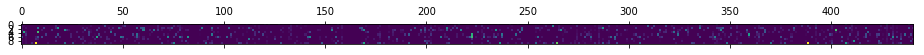

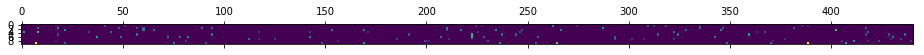

average non-zeros [3242 1489 3348  354  370  601  586  802  501 1300  958  504  454  626
  374  481  377 1225  737  529  570  750  771  595  639  642  927  960
  609  387 2910  416  572 1334 2492 1039 1080  414 1320  843  377 1028
  584  491  882  569  530  567  939  938  596  576 1094  603  560  629
 1103  782 2378  566  421  329  571 1193  546  566  309  617  354  925
  486  564 2629 1066  851  422  460  668 2204 2609  784  523 2418  545
  466  506  401  612 1950  836  933  812  854  742  603  790  574  986
  623  614  228  780  502 1128  622  926  855  626  920  720  856 2908
  441  249  609 1020  322 2290  413  466]
average non-zeros [189 127 174  79 104 164 131 143  82 160 153 160 170 132 132 107 120 116
 111 107 111 169 113 143 152 103  95 146 141  82 182 155 104 152 157 166
  87  95 143 148 101 201 129  97 122 130 115  84 101 174 129 115 109  86
 128 137 131 134 143 116 144 112 116 123 126  93 102 113  85 119  94 131
 133 124 138  98 111 145 141 157 100 103 110 110 112  89 102 1

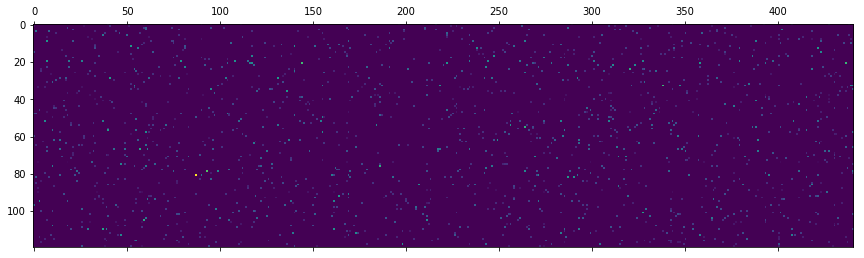

<Figure size 1080x216 with 0 Axes>

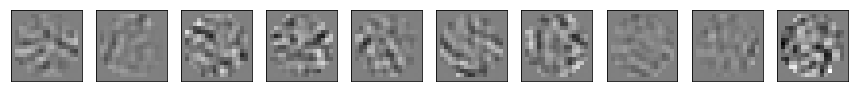

<Figure size 1080x216 with 0 Axes>

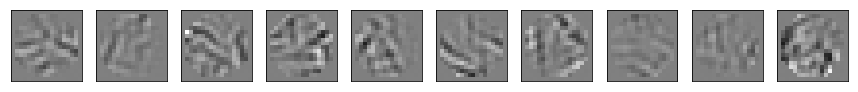

<Figure size 1080x216 with 0 Axes>

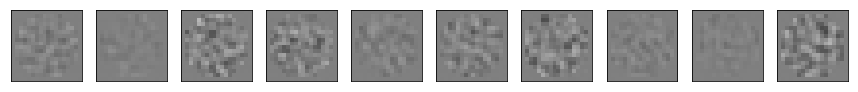

mean deviation of coefficients =  0.05361832928787703 0.022280185799758653 0.021645600112706217
total deviation of coefficients =  0.016166489718225735
mean deviation of quantiles =  0.0031621643031910615
mean deviation of quantiles =  0.0031578515799211226
total deviation of quantiles =  0.0023855839994271553
ratio deviation of quantiles =  0.7544149420129026
proba incorrect coefficients =  0.193318961699263
proba incorrect coefficients (strong) =  0.02209777140022673
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


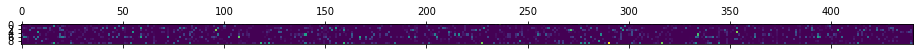

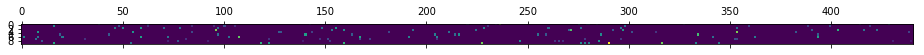

average non-zeros [ 953 2382  791  829 1507  861 1000  674 1388  801  692 1257 1661 2307
 1930 1926  907  730  839  773 1728  562 1043 2143 1196  816 1062  958
  757 2386 1202 1222 1212 1655  990 1182 1109  505  943 1115 1398 1605
 1015  868  982  641 1379  820 1089  402  619 1860 1243 1203  867 1049
  762  779  577 1556 1544 1150  898  913 1156 2807  778  835  642  954
 1422 1257 1622  610  794  938 1653 1039  954  654 1025 1031  912  636
 1575  898 1239 1298 1024  614  925 1366 2222 1021  588 2216  729  496
  982 1754 1213  726  707  963  821  864  373 3014 1728  673 1344 2145
 1391  685  864  618  458  611  952  652]
average non-zeros [117 114  81 106 160 124 103 105 131 100 151 104 150  58 142 133 100 121
 107 114  85  95  69 101 115 149 144 122 101 124 153  95  92 124 111 130
 110 106 164 129 116 107 171 114 123 128 135 130 129  95 101  77 152 154
 133  93 109 117  96 133 151 151 122  89 159 210 116 143 110 134 106 107
 152  99  98 121 118 148 163 108 141 127  67 106 162 140 146  

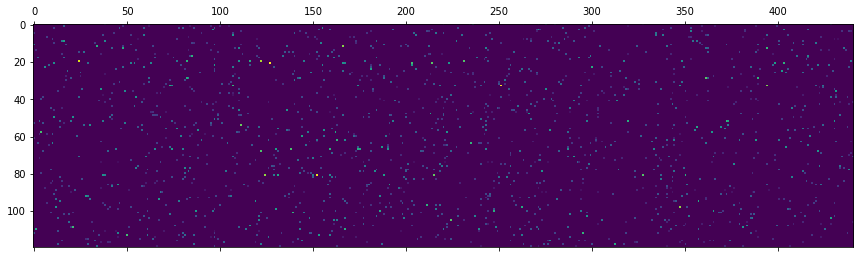

<Figure size 1080x216 with 0 Axes>

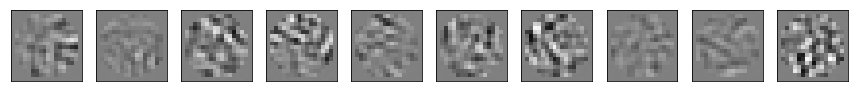

<Figure size 1080x216 with 0 Axes>

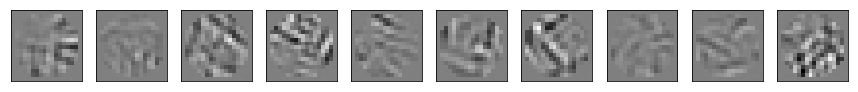

<Figure size 1080x216 with 0 Axes>

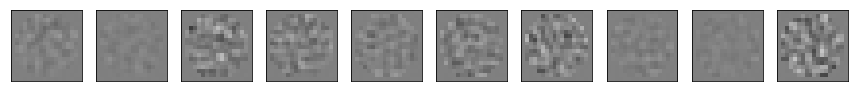

mean deviation of coefficients =  0.05755100736737344 0.02244464566260491 0.02168018118912973
total deviation of coefficients =  0.016499848684240263
mean deviation of quantiles =  0.003162347182716103
mean deviation of quantiles =  0.0031579391466668946
total deviation of quantiles =  0.0024343837813803463
ratio deviation of quantiles =  0.7698028207293428
proba incorrect coefficients =  0.24620723940617917
proba incorrect coefficients (strong) =  0.022419970592403637
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


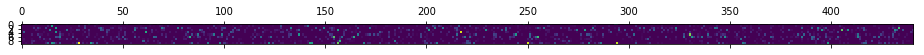

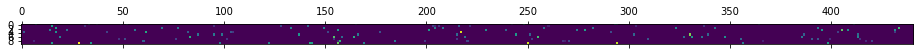

average non-zeros [1229 1041 1003 1806 1021 1592 1501 1146 1318 1331 1241 1044 1226 1348
 1247 1304 1060  983  793 1478 1022 1463 1438 1047 1272 1650 1054 1423
  991 1039 1476 1337  912 1928  888  883 1683 1023  919 1144  976  823
 1224 1453 1570 1742 1667 1005 1297  974 1336 1320 1533  701 1113 1275
  846 1915 1382 1310 1493 1165 1251 1440  878 1248  912 1871  873 1592
 1021 1294 1126 1069  822  942 1208  772 1163 1161 1300 1646 1175  973
 1281 1006  817 1373 1373 1337 1392  840 1034 1568  865 1161 1068 1574
  998 1322 1732 1315 1145 1242 1217 1212  974 1779 1084  895 1384 1275
  584  708 1355 1510  961 1065  971 1608]
average non-zeros [110 126 108 115 118 128 125 136 128 147 118 122 106 100  94 151 118 123
  99 142 109 108 133 109 108 139 119 123 146 112 114 140 113 106 117 118
 102 127 118 130 123 100 139 130 131 139 157 119 113 125 144 109 111 117
 125 123 107 130 110 107 108 125 121 103 128 139 146 113  97 136 126 102
  99 147 106 104 112 101 127  90 128 159 175 104 124 140  96 1

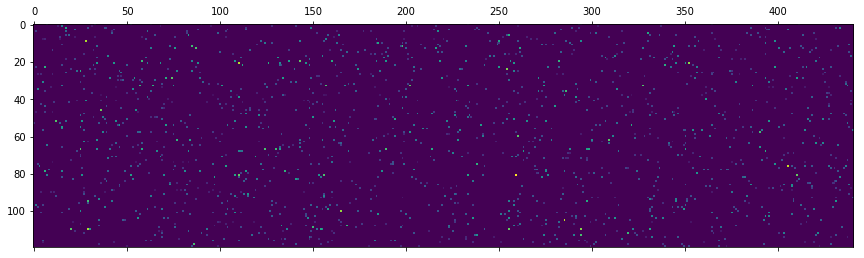

<Figure size 1080x216 with 0 Axes>

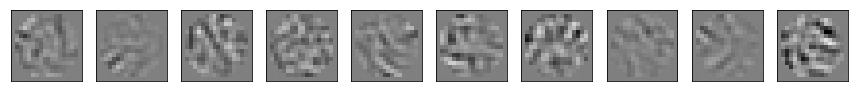

<Figure size 1080x216 with 0 Axes>

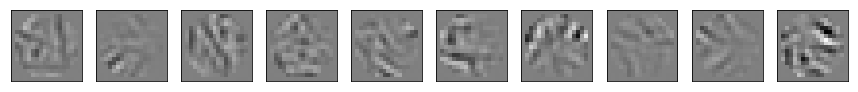

<Figure size 1080x216 with 0 Axes>

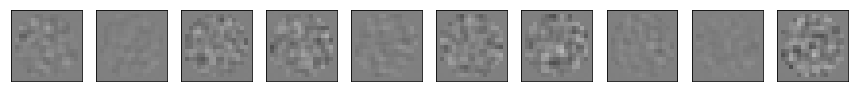

mean deviation of coefficients =  0.05945177503319239 0.02269467189061418 0.022096013501146056
total deviation of coefficients =  0.016414163616699354
mean deviation of quantiles =  0.003162306056396684
mean deviation of quantiles =  0.0031593499134936363
total deviation of quantiles =  0.00235434732914528
ratio deviation of quantiles =  0.744503310924927
proba incorrect coefficients =  0.26679034243905897
proba incorrect coefficients (strong) =  0.021812663867630366


In [10]:
def shuffling(data, sparse_code, dico, N_show=10):
    if do_random:
        from shl_scripts.shl_encode import inv_quantile, inv_rescaling
        sparse_code_bar = inv_rescaling(inv_quantile(dico.P_cum, np.random.rand(sparse_code.shape[0], sparse_code.shape[1])), C=shl.C)
    else:
        sparse_code = sparse_encode(data, dico.dictionary, P_cum=dico.P_cum, C=shl.C, 
                                     l0_sparseness=l0_sparseness_noise, gain=None)   

        sparse_code_bar = sparse_code.copy()
        
        sparse_code_bar = sparse_code_bar.T
        np.random.shuffle(sparse_code_bar)
        sparse_code_bar = sparse_code_bar.T
        
        if do_double_shuffle:
            np.random.shuffle(sparse_code_bar)

    plt.matshow(sparse_code_bar[:N_show, :])
    plt.show()

    def threshold(sparse_code, l0_sparseness):
        thr = np.percentile(sparse_code, 100 * (1 - l0_sparseness/shl.n_dictionary ), axis=1)
        return (sparse_code>thr[:, np.newaxis])

    sparse_code_bar_high = threshold(sparse_code_bar, shl.l0_sparseness) * sparse_code_bar
    plt.matshow(sparse_code_bar_high[:N_show, :])
    plt.show()
    return sparse_code_bar, sparse_code_bar_high

def pipeline(sparse_code_bar, sparse_code_bar_high, dico, index, N_show=120):

    patches_bar = sparse_code_bar @ dico.dictionary
    SD = np.sqrt(np.mean(patches_bar**2, axis=1))


    P_cum_rec = dico.P_cum
    gain_rec = None

    sparse_code_rec = sparse_encode(patches_bar, dico.dictionary, P_cum=P_cum_rec, C=shl.C, 
                                     l0_sparseness=shl.l0_sparseness, gain=gain_rec)   

    print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_bar_high, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_rec, axis=0)[:N_show])
    
    from shl_scripts.shl_tools import print_stats
    SD, SE = print_stats(patches_bar, dico.dictionary, sparse_code_rec, verbose=False, display=True)
    #plt.matshow(sparse_code_rec[:N_show, :])
    plt.show()

    print('mean deviation of coefficients = ', np.mean(np.abs(sparse_code_bar)), np.mean(np.abs(sparse_code_bar_high)), np.mean(np.abs(sparse_code_rec)))
    print('total deviation of coefficients = ', np.mean(np.abs(sparse_code_bar_high-sparse_code_rec)))

    from shl_scripts.shl_encode import quantile, rescaling

    q_rec = quantile(dico.P_cum, rescaling(sparse_code_rec, C=shl.C), stick, do_fast=False)
    q_bar = quantile(dico.P_cum, rescaling(sparse_code_bar_high, C=shl.C), stick, do_fast=False)

    print('mean deviation of quantiles = ', np.mean(np.abs(q_bar)))
    print('mean deviation of quantiles = ', np.mean(np.abs(q_rec)))
    print('total deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec)))
    print('ratio deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar)))
    aerror = np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar))

    perror = 1 - np.mean( (sparse_code_bar>0) == (sparse_code_rec>0))
    print('proba incorrect coefficients = ', perror)

    perror_high = 1 - np.mean( (sparse_code_bar_high > 0) == (sparse_code_rec>0))
    print('proba incorrect coefficients (strong) = ', perror_high)
    
    return pd.DataFrame({'error':[(SD/SE).mean()],
                               'aerror':[aerror],
                               'perror':[perror],
                               'perror_high':[perror_high]
                                        },
                                index=[index])

record = None
for homeo_method in homeo_methods:
    print(42*'🐶')
    print(19*'🐶' + homeo_method + 10*'🐶')
    print(42*'🐶')

    shl = SHL(homeo_method=homeo_method)

    sparse_code_bar, sparse_code_bar_high = shuffling(data[indx, :], sparse_code, dico[homeo_method])
    record_ = pipeline(sparse_code_bar, sparse_code_bar_high, dico[homeo_method], index=homeo_method)
    if record is None:
        record = record_
    else:
        record = pd.concat((record, record_))


In [7]:
record

,aerror,error,perror,perror_high
None,0.745161,2.261322,0.193120,0.021990
HAP,0.752933,2.237894,0.246187,0.022153
HEH,0.748043,2.301841,0.266800,0.022013


## Version used

In [9]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.1)]
IPython 6.4.0
OS Darwin 17.5.0 x86_64 i386 64bit
numpy 1.14.3
shl_scripts 20171221
pandas 0.22.0
Fri May 11 15:22:09 2018 CEST